# SQL Assessment

## Imports

In [1]:
import os
import pandas as pd
from sqlalchemy import create_engine, Integer, Float, String, Column, MetaData, Table

## Database creation and data loading

In [2]:
# Get path to file
current_dir = os.getcwd() 
file_path = os.path.join(current_dir, 'AirQualityUCI.csv') 
df = pd.read_csv(file_path, delimiter=';') 
df = df.dropna(how="all")

In [3]:
# Inspect the column names
print("Column Names in CSV:", df.columns)

Column Names in CSV: Index(['Date', 'Time', 'CO(GT)', 'PT08.S1(CO)', 'NMHC(GT)', 'C6H6(GT)',
       'PT08.S2(NMHC)', 'NOx(GT)', 'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)',
       'PT08.S5(O3)', 'T', 'RH', 'AH', 'Unnamed: 15', 'Unnamed: 16'],
      dtype='object')


In [4]:
# Remove the last column if it's empty (due to trailing semicolons)
if df.columns[-1] == '':
    df = df.iloc[:, :-1]

In [5]:
# Remove any trailing empty columns and clean column names
df.columns = df.columns.str.strip().str.replace('[()]', '', regex=True).str.replace(' ', '_').str.replace('.', '_')
print(df.columns)

Index(['Date', 'Time', 'COGT', 'PT08_S1CO', 'NMHCGT', 'C6H6GT', 'PT08_S2NMHC',
       'NOxGT', 'PT08_S3NOx', 'NO2GT', 'PT08_S4NO2', 'PT08_S5O3', 'T', 'RH',
       'AH', 'Unnamed:_15', 'Unnamed:_16'],
      dtype='object')


In [6]:
# Drop completely empty columns
df.drop(columns=['Unnamed:_15', 'Unnamed:_16'], inplace=True)

In [7]:
# Create a connection to the SQLite database
db_path = os.path.join(current_dir, 'AirQualityDB.db') 
engine = create_engine(f'sqlite:///{db_path}', echo=True)
metadata = MetaData()

# Define the table 
air_quality_table = Table(
    'AirQuality', metadata,
    Column('Date', String),
    Column('Time', String),
    Column('CO', Integer),
    Column('PT08_S1_CO', Integer),
    Column('NMHC', Integer),
    Column('C6H6', Float),
    Column('PT08_S2_NMHC', Integer),
    Column('NOx', Integer),
    Column('PT08_S3_NOx', Integer),
    Column('NO2', Integer),
    Column('PT08_S4_NO2', Integer),
    Column('PT08_S5_O3', Integer),
    Column('T', Float),
    Column('RH', Float),
    Column('AH', Float)
)

# Create the table in the database
metadata.create_all(engine)

2024-08-08 00:38:29,275 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2024-08-08 00:38:29,275 INFO sqlalchemy.engine.Engine PRAGMA main.table_info("AirQuality")
2024-08-08 00:38:29,275 INFO sqlalchemy.engine.Engine [raw sql] ()
2024-08-08 00:38:29,277 INFO sqlalchemy.engine.Engine COMMIT


In [8]:
# Write the data to the SQLite table
df.to_sql('AirQuality', engine, if_exists='replace', index=False)

2024-08-08 00:38:29,283 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2024-08-08 00:38:29,287 INFO sqlalchemy.engine.Engine PRAGMA main.table_info("AirQuality")
2024-08-08 00:38:29,287 INFO sqlalchemy.engine.Engine [raw sql] ()
2024-08-08 00:38:29,288 INFO sqlalchemy.engine.Engine PRAGMA main.table_info("AirQuality")
2024-08-08 00:38:29,289 INFO sqlalchemy.engine.Engine [raw sql] ()
2024-08-08 00:38:29,289 INFO sqlalchemy.engine.Engine SELECT name FROM sqlite_master WHERE type='table' ORDER BY name
2024-08-08 00:38:29,290 INFO sqlalchemy.engine.Engine [raw sql] ()
2024-08-08 00:38:29,291 INFO sqlalchemy.engine.Engine PRAGMA main.table_xinfo("AirQuality")
2024-08-08 00:38:29,291 INFO sqlalchemy.engine.Engine [raw sql] ()
2024-08-08 00:38:29,292 INFO sqlalchemy.engine.Engine SELECT sql FROM  (SELECT * FROM sqlite_master UNION ALL   SELECT * FROM sqlite_temp_master) WHERE name = ? AND type = 'table'
2024-08-08 00:38:29,293 INFO sqlalchemy.engine.Engine [raw sql] ('AirQuality',)
2024-08-0

9357

## Worst Air Quality

In [9]:
worst_air_quality_query = """
SELECT SUM(COGT + C6H6GT + NO2GT) AS AIR_QUALITY, * FROM AirQuality
ORDER BY AIR_QUALITY DESC LIMIT 1
"""

# Perform the query
with engine.connect() as connection:
    result = connection.execute(worst_air_quality_query)
    worst_air_quality_record = result.fetchone()

2024-08-08 00:38:29,463 INFO sqlalchemy.engine.Engine 
SELECT SUM(COGT + C6H6GT + NO2GT) AS AIR_QUALITY, * FROM AirQuality
ORDER BY AIR_QUALITY DESC LIMIT 1

2024-08-08 00:38:29,464 INFO sqlalchemy.engine.Engine [raw sql] ()


In [10]:
print("Worst Air Quality Record:")
print(worst_air_quality_record)

Worst Air Quality Record:
(233991.0, '10/03/2004', '18.00.00', '2,6', 1360.0, 150.0, '11,9', 1046.0, 166.0, 1056.0, 113.0, 1692.0, 1268.0, '13,6', '48,9', '0,7578')


## Average and Variability

In [11]:
avg_variance_query = """SELECT 
AVG(NO2GT) as avg_NO2, 
(AVG(NO2GT*NO2GT) - AVG(NO2GT)*AVG(NO2GT)) as variance_NO2
FROM AirQuality"""

In [12]:
# Execute the query and fetch the result
with engine.connect() as connection:
    result = connection.execute(avg_variance_query)
    avg_variance_result = result.fetchone()

2024-08-08 00:38:29,482 INFO sqlalchemy.engine.Engine SELECT 
AVG(NO2GT) as avg_NO2, 
(AVG(NO2GT*NO2GT) - AVG(NO2GT)*AVG(NO2GT)) as variance_NO2
FROM AirQuality
2024-08-08 00:38:29,482 INFO sqlalchemy.engine.Engine [raw sql] ()


In [13]:
# Calculate the standard deviation in Python
avg_NO2 = avg_variance_result['avg_NO2']
variance_NO2 = avg_variance_result['variance_NO2']
stddev_NO2 = variance_NO2 ** 0.5

# Print the results
print("Average of NO2:", avg_NO2)
print("Standard Deviation of NO2:", stddev_NO2)

Average of NO2: 58.14887250187026
Standard Deviation of NO2: 126.93367189634309


## CO(GT) and T

In [14]:
cogt_t_query = """
SELECT * FROM AirQuality WHERE COGT > 2 AND T < 15
"""

# Execute the query and fetch the result
with engine.connect() as connection:
    result = connection.execute(cogt_t_query)
    cogt_t_result = result.fetchall()

2024-08-08 00:38:29,494 INFO sqlalchemy.engine.Engine 
SELECT * FROM AirQuality WHERE COGT > 2 AND T < 15

2024-08-08 00:38:29,495 INFO sqlalchemy.engine.Engine [raw sql] ()


In [15]:
cogt_t_result

[('10/03/2004', '18.00.00', '2,6', 1360.0, 150.0, '11,9', 1046.0, 166.0, 1056.0, 113.0, 1692.0, 1268.0, '13,6', '48,9', '0,7578'),
 ('10/03/2004', '20.00.00', '2,2', 1402.0, 88.0, '9,0', 939.0, 131.0, 1140.0, 114.0, 1555.0, 1074.0, '11,9', '54,0', '0,7502'),
 ('10/03/2004', '21.00.00', '2,2', 1376.0, 80.0, '9,2', 948.0, 172.0, 1092.0, 122.0, 1584.0, 1203.0, '11,0', '60,0', '0,7867'),
 ('11/03/2004', '09.00.00', '2,2', 1351.0, 87.0, '9,5', 960.0, 129.0, 1079.0, 101.0, 1583.0, 1028.0, '10,5', '60,6', '0,7691'),
 ('11/03/2004', '18.00.00', '4,8', 1581.0, 307.0, '20,8', 1319.0, 281.0, 799.0, 151.0, 2083.0, 1409.0, '10,3', '64,2', '0,8065'),
 ('12/03/2004', '10.00.00', '3,1', 1350.0, 208.0, '14,0', 1118.0, 187.0, 912.0, 122.0, 1712.0, 1237.0, '13,2', '41,7', '0,6320'),
 ('12/03/2004', '11.00.00', '2,7', 1263.0, 166.0, '11,6', 1037.0, 216.0, 969.0, 143.0, 1598.0, 1167.0, '14,3', '38,4', '0,6243'),
 ('12/03/2004', '19.00.00', '3,7', 1525.0, 242.0, '18,2', 1246.0, 202.0, 821.0, 145.0, 1847.0, 

In [16]:
print("Number of results:", len(cogt_t_result))

Number of results: 882


# Python assessment

## Imports

In [17]:
import numpy as np
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, classification_report, silhouette_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sqlalchemy import create_engine

## Data Exploration

In [18]:
# Get path to file
current_dir = os.getcwd() 
file_path = os.path.join(current_dir, 'AirQualityUCI.csv') 
# Create a connection to the SQLite database
db_path = os.path.join(current_dir, 'AirQualityDB.db') 
engine = create_engine(f'sqlite:///{db_path}', echo=True)

In [19]:
query = """SELECT * FROM AirQuality"""
df = pd.read_sql_query(query, engine)

2024-08-08 00:38:30,859 INFO sqlalchemy.engine.Engine SELECT * FROM AirQuality
2024-08-08 00:38:30,859 INFO sqlalchemy.engine.Engine [raw sql] ()


In [20]:
# Inspect the data structure and summary statistics
print(df.head())
print(df.info())
print(df.describe())

         Date      Time COGT  PT08_S1CO  NMHCGT C6H6GT  PT08_S2NMHC  NOxGT  \
0  10/03/2004  18.00.00  2,6     1360.0   150.0   11,9       1046.0  166.0   
1  10/03/2004  19.00.00    2     1292.0   112.0    9,4        955.0  103.0   
2  10/03/2004  20.00.00  2,2     1402.0    88.0    9,0        939.0  131.0   
3  10/03/2004  21.00.00  2,2     1376.0    80.0    9,2        948.0  172.0   
4  10/03/2004  22.00.00  1,6     1272.0    51.0    6,5        836.0  131.0   

   PT08_S3NOx  NO2GT  PT08_S4NO2  PT08_S5O3     T    RH      AH  
0      1056.0  113.0      1692.0     1268.0  13,6  48,9  0,7578  
1      1174.0   92.0      1559.0      972.0  13,3  47,7  0,7255  
2      1140.0  114.0      1555.0     1074.0  11,9  54,0  0,7502  
3      1092.0  122.0      1584.0     1203.0  11,0  60,0  0,7867  
4      1205.0  116.0      1490.0     1110.0  11,2  59,6  0,7888  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9357 entries, 0 to 9356
Data columns (total 15 columns):
 #   Column       Non-Null C

### General Patterns in Pollutant Concentrations
**Mean Values:**

- The mean concentration of NO2(GT) is 58.15, with a standard deviation of 126.95.
- CO(GT) has a mean of 2.87, indicating the average carbon monoxide level recorded.
- C6H6(GT) (Benzene) has a mean of 9.77, indicating the average benzene concentration.

**Standard Deviations:**

- The standard deviations are relatively high for most pollutants, indicating significant variability in the recorded values.
- For example, NO2(GT) has a standard deviation of 126.95, which is more than twice its mean value.

**Minimum and Maximum Values:**

- Several columns have a minimum value of -200, which appears to be an outlier or an error value.
- Maximum values are significantly higher than the mean, suggesting potential outliers or extreme pollution events.

### Outliers and Missing Values
**Outliers:**
- Values such as -200 for several pollutants likely represent errors or placeholder values for missing data.
- To handle these, we can replace these outliers with NaN and then decide on a strategy to impute or drop these rows.

**Missing Values:**
- Other columns do not have explicit missing values, but the -200 values suggest missing or erroneous data that need to be addressed.
- Columns 'CO(GT)', 'C6H6(GT)', 'T', 'RH', 'AH' were not loaded as float due to the decimal comma instead of the dot.

## Data Preprocessing

In [21]:
# Replace commas with dots for specific columns
columns_to_convert = ['COGT', 'C6H6GT', 'T', 'RH', 'AH']
for column in columns_to_convert:
    df[column] = df[column].str.replace(',', '.').astype(float)

In [22]:
# Inspect the data types after conversion
print(df.dtypes)

Date            object
Time            object
COGT           float64
PT08_S1CO      float64
NMHCGT         float64
C6H6GT         float64
PT08_S2NMHC    float64
NOxGT          float64
PT08_S3NOx     float64
NO2GT          float64
PT08_S4NO2     float64
PT08_S5O3      float64
T              float64
RH             float64
AH             float64
dtype: object


In [23]:
# Replace -200 with NaN for relevant columns
df.replace(-200, np.nan, inplace=True)

In [24]:
# Drop rows with missing values or use imputation
df.dropna(how='all', inplace=True)

In [25]:
# Handle remaining NaN values
# Forward fill
df.fillna(method='ffill', inplace=True)

In [26]:
# Inspect the data again
print(df.head())
print(df.info())
print(df.describe())

         Date      Time  COGT  PT08_S1CO  NMHCGT  C6H6GT  PT08_S2NMHC  NOxGT  \
0  10/03/2004  18.00.00   2.6     1360.0   150.0    11.9       1046.0  166.0   
1  10/03/2004  19.00.00   2.0     1292.0   112.0     9.4        955.0  103.0   
2  10/03/2004  20.00.00   2.2     1402.0    88.0     9.0        939.0  131.0   
3  10/03/2004  21.00.00   2.2     1376.0    80.0     9.2        948.0  172.0   
4  10/03/2004  22.00.00   1.6     1272.0    51.0     6.5        836.0  131.0   

   PT08_S3NOx  NO2GT  PT08_S4NO2  PT08_S5O3     T    RH      AH  
0      1056.0  113.0      1692.0     1268.0  13.6  48.9  0.7578  
1      1174.0   92.0      1559.0      972.0  13.3  47.7  0.7255  
2      1140.0  114.0      1555.0     1074.0  11.9  54.0  0.7502  
3      1092.0  122.0      1584.0     1203.0  11.0  60.0  0.7867  
4      1205.0  116.0      1490.0     1110.0  11.2  59.6  0.7888  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9357 entries, 0 to 9356
Data columns (total 15 columns):
 #   Column     

### Standarization and normalization

In [27]:
# Standardize the variables
scaler = StandardScaler()
df[columns_to_convert] = scaler.fit_transform(df[columns_to_convert])

# Normalize the variables
min_max_scaler = MinMaxScaler()
df[columns_to_convert] = min_max_scaler.fit_transform(df[columns_to_convert])

- Standardizing and normalizing variables is important to ensure that all features contribute equally to the analysis and modeling. It helps in algorithms that rely on the distance between data points, such as k-nearest neighbors (KNN), support vector machines (SVM), and clustering algorithms like k-means.
- Standardization rescales the data to have a mean of 0 and a standard deviation of 1.
- Normalization rescales the data to a range of [0, 1] or [-1, 1].

### Feature engineering and transformations

In [28]:
# Creates an index of air quality
df['AirQualityIndex'] = df[['COGT', 'C6H6GT', 'NO2GT']].sum(axis=1)

In [29]:
# Encode date and time into separate features
df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y', errors='coerce')
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day

In [30]:
# Extract hour from the time column
df['Time'] = df['Time'].str.split('.').str[0]  # Extract the hour part
df['Hour'] = df['Time'].astype(int)

# Drop original 'Date' and 'Time' columns if not needed
df.drop(columns=['Date', 'Time'], inplace=True)

In [31]:
# Inspect the transformed data
print(df.head())
print(df.info())
print(df.describe())

       COGT  PT08_S1CO  NMHCGT    C6H6GT  PT08_S2NMHC  NOxGT  PT08_S3NOx  \
0  0.211864     1360.0   150.0  0.185535       1046.0  166.0      1056.0   
1  0.161017     1292.0   112.0  0.146226        955.0  103.0      1174.0   
2  0.177966     1402.0    88.0  0.139937        939.0  131.0      1140.0   
3  0.177966     1376.0    80.0  0.143082        948.0  172.0      1092.0   
4  0.127119     1272.0    51.0  0.100629        836.0  131.0      1205.0   

   NO2GT  PT08_S4NO2  PT08_S5O3         T        RH        AH  \
0  113.0      1692.0     1268.0  0.333333  0.499371  0.280066   
1   92.0      1559.0      972.0  0.326882  0.484277  0.264282   
2  114.0      1555.0     1074.0  0.296774  0.563522  0.276352   
3  122.0      1584.0     1203.0  0.277419  0.638994  0.294190   
4  116.0      1490.0     1110.0  0.281720  0.633962  0.295216   

   AirQualityIndex  Year  Month  Day  Hour  
0       113.397399  2004      3   10    18  
1        92.307243  2004      3   10    19  
2       114.31790

## Predictive Analysis

### Regression Model to Predict NO2 Concentrations

In [32]:
# Define features and target for regression
X_reg = df.drop(columns=['NO2GT', 'AirQualityIndex'])
y_reg = df['NO2GT']

# Split the data into training and testing sets
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X_reg, y_reg, test_size=0.2, random_state=42)

# Train a linear regression model
reg_model = LinearRegression()
reg_model.fit(X_train_reg, y_train_reg)

# Predict on the test set
y_pred_reg = reg_model.predict(X_test_reg)

# Evaluate the regression model
print("Regression Model Performance:")
print("RMSE:", np.sqrt(mean_squared_error(y_test_reg, y_pred_reg)))
print("R²:", r2_score(y_test_reg, y_pred_reg))

Regression Model Performance:
RMSE: 20.81543312576174
R²: 0.800363513741009


### Classification Model to Predict Air Quality


In [33]:
# Define air quality categories based on NO2 concentrations
def classify_air_quality(no2):
    if no2 < 50:
        return 'Good Air'
    elif no2 < 100:
        return 'Moderate'
    else:
        return 'Bad'

In [34]:
df['AirQuality'] = df['NO2GT'].apply(classify_air_quality)

# Define features and target for classification
X_clf = df.drop(columns=['NO2GT', 'AirQualityIndex', 'AirQuality'])
y_clf = df['AirQuality']

# Split the data into training and testing sets
X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(X_clf, y_clf, test_size=0.2, random_state=42)

# Train a Random Forest classifier
clf = RandomForestClassifier()
clf.fit(X_train_clf, y_train_clf)

# Predict on the test set
y_pred_clf = clf.predict(X_test_clf)

In [35]:
# Evaluate the classification model
print("Classification Model Performance:")
print("Accuracy:", accuracy_score(y_test_clf, y_pred_clf))
print(classification_report(y_test_clf, y_pred_clf))

Classification Model Performance:
Accuracy: 0.9214743589743589
              precision    recall  f1-score   support

         Bad       0.95      0.94      0.95      1009
    Good Air       0.91      0.81      0.86       141
    Moderate       0.88      0.92      0.90       722

    accuracy                           0.92      1872
   macro avg       0.92      0.89      0.90      1872
weighted avg       0.92      0.92      0.92      1872



## Clustering Analysis


In [36]:
# Select features for clustering
features = df[['COGT', 'C6H6GT', 'NO2GT', 'T', 'RH', 'AH']]

# Determine the optimal number of clusters using the elbow method
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=42)
    kmeans.fit(features)
    wcss.append(kmeans.inertia_)

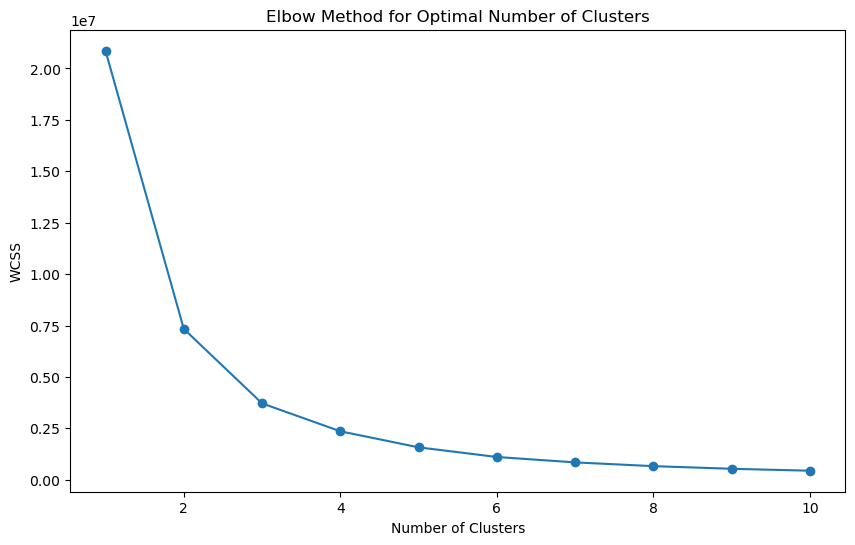

In [37]:
# Plot the elbow method
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), wcss, marker='o')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()

Cluster Centers:
 [[1.76317359e-01 1.71579620e-01 1.14103182e+02 4.43193248e-01
  4.72575402e-01 3.89067532e-01]
 [8.09540399e-02 9.07467359e-02 6.32651177e+01 4.60371363e-01
  5.39041110e-01 4.79396461e-01]
 [3.07066113e-01 2.52794871e-01 1.82566955e+02 3.69558048e-01
  4.82231686e-01 3.15534391e-01]]


Text(0, 0.5, 'NO2(GT)')

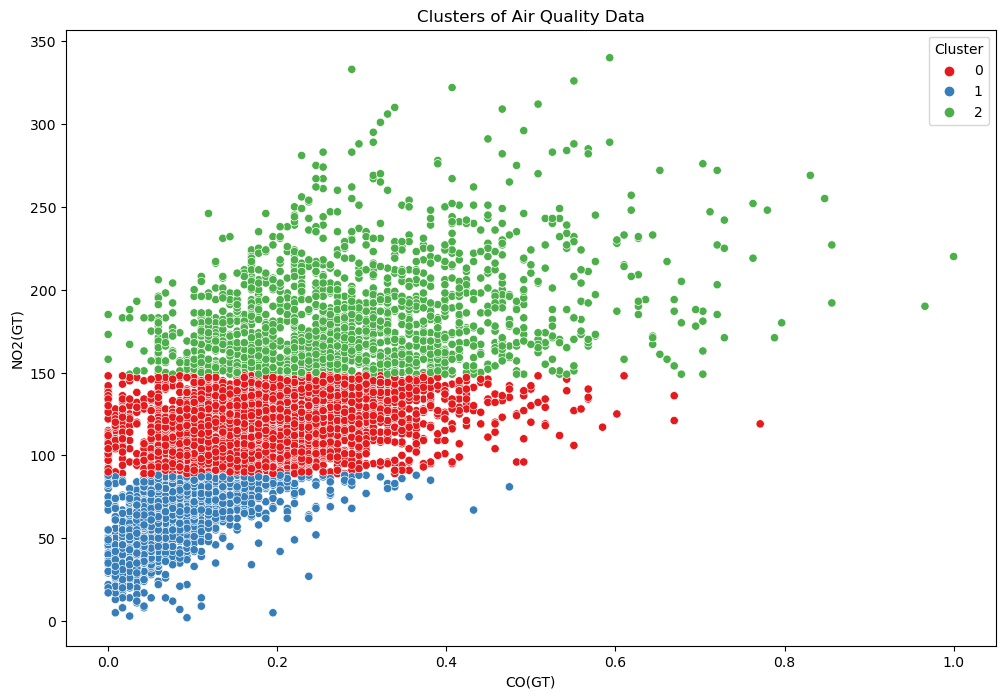

In [38]:
# Based on the elbow plot, chosen optimal number of clusters
optimal_clusters = 3

# Apply K-Means clustering with the optimal number of clusters
kmeans = KMeans(n_clusters=optimal_clusters, init='k-means++', max_iter=300, n_init=10, random_state=42)
df['Cluster'] = kmeans.fit_predict(features)

# Analyze the clusters
cluster_centers = kmeans.cluster_centers_
print("Cluster Centers:\n", cluster_centers)

# Visualize the clusters
plt.figure(figsize=(12, 8))
sns.scatterplot(x='COGT', y='NO2GT', hue='Cluster', palette='Set1', data=df)
plt.title('Clusters of Air Quality Data')
plt.xlabel('CO(GT)')
plt.ylabel('NO2(GT)')

### Analyzing and Interpreting the Clusters

#### Cluster Descriptions

1. **Cluster 0 (Red)**:
   - **Characteristics**: Moderate `NO2(GT)` (75-150) and low to moderate `CO(GT)` (0.1-0.3).
   - **Interpretation**: Represents areas with moderate pollution levels.

2. **Cluster 1 (Blue)**:
   - **Characteristics**: Low `NO2(GT)` (up to 100) and low `CO(GT)` (up to 0.2).
   - **Interpretation**: Indicates areas with good air quality.

3. **Cluster 2 (Green)**:
   - **Characteristics**: High `NO2(GT)` (100-350) and moderate to high `CO(GT)` (0.2-1.0).
   - **Interpretation**: Represents areas with poor air quality.

#### Insights and Actionable Information


1. **Pollution Distribution**:
   - Clusters show clear separation of pollution levels: Cluster 1 (good), Cluster 0 (moderate), Cluster 2 (poor).

2. **Targeted Interventions**:
   - **Cluster 2**: Requires stricter pollution control measures.
   - **Cluster 0**: Preventive measures to avoid worsening pollution.
   - **Cluster 1**: Maintain current good air quality standards.

3. **Policy Implications**:
   - Allocate resources and enforce regulations based on cluster-specific needs.
   - Monitor changes in cluster compositions to evaluate the impact of interventions.

4. **Public Awareness**:
   - Educate residents in high pollution areas (Cluster 2) about health impacts and emission reduction strategies.
   - Encourage behaviors that contribute to better air quality, such as using public transport.



## Validation and Evaluation


In [39]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import make_scorer

# Define the KFold cross-validator
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Regression Mode Cross-validation
reg_model = LinearRegression()
mse_scorer = make_scorer(mean_squared_error)
r2_scorer = make_scorer(r2_score)

mse_scores = cross_val_score(reg_model, X_reg, y_reg, cv=kf, scoring=mse_scorer)
r2_scores = cross_val_score(reg_model, X_reg, y_reg, cv=kf, scoring=r2_scorer)

In [40]:
print("Regression Model Cross-Validation Performance:")
print("MSE scores:", mse_scores)
print("Mean MSE:", mse_scores.mean())
print("R² scores:", r2_scores)
print("Mean R²:", r2_scores.mean())

Regression Model Cross-Validation Performance:
MSE scores: [433.28225621 472.33049703 467.40382338 446.35455391 431.87171919]
Mean MSE: 450.2485699433619
R² scores: [0.80036351 0.79894722 0.78801578 0.80424453 0.7981689 ]
Mean R²: 0.7979479887832504


**Mean Squared Error (MSE)**

- The MSE scores across the folds range from approximately 431.87 to 472.33.
- The variability in MSE scores is relatively small, indicating that the model's prediction error is consistent across different subsets of the data.

**Coefficient of Determination (R²)**
- The R² scores range from approximately 0.7880 to 0.8042.
- The variability in R² scores is also small, suggesting that the model consistently explains around 79.8% of the variance in the target variable across different data splits.

The performance metrics (MSE and R²) show little variability across the different folds of cross-validation. This indicates that the regression model has stable performance and generalizes well to different subsets of the data.

In [41]:
# Classification Model Cross-validation
clf = RandomForestClassifier()

accuracy_scores = cross_val_score(clf, X_clf, y_clf, cv=kf, scoring='accuracy')
precision_scores = cross_val_score(clf, X_clf, y_clf, cv=kf, scoring='precision_macro')
recall_scores = cross_val_score(clf, X_clf, y_clf, cv=kf, scoring='recall_macro')
f1_scores = cross_val_score(clf, X_clf, y_clf, cv=kf, scoring='f1_macro')

In [42]:
print("Classification Model Cross-Validation Performance:")
print("Accuracy scores:", accuracy_scores)
print("Mean Accuracy:", accuracy_scores.mean())
print("Precision scores:", precision_scores)
print("Mean Precision:", precision_scores.mean())
print("Recall scores:", recall_scores)
print("Mean Recall:", recall_scores.mean())
print("F1 scores:", f1_scores)
print("Mean F1:", f1_scores.mean())

Classification Model Cross-Validation Performance:
Accuracy scores: [0.92681624 0.91399573 0.92891502 0.91982897 0.91662213]
Mean Accuracy: 0.9212356160378607
Precision scores: [0.92181077 0.91007698 0.92955853 0.91347807 0.91215157]
Mean Precision: 0.9174151834697846
Recall scores: [0.89253232 0.87619365 0.90133734 0.86254372 0.88164409]
Mean Recall: 0.8828502245559153
F1 scores: [0.90500297 0.89022477 0.91483204 0.88449644 0.89886493]
Mean F1: 0.8986842287010145


- The accuracy scores do not vary much across folds, indicating reliable performance.
- Precision scores are stable across folds, indicating consistent identification of positive instances.
- Recall scores show slight variability, but the overall mean recall is still high.
- F1 scores, balancing precision and recall, show consistent performance, reflecting the model's robustness.

The classification model demonstrates stable performance across different folds of cross-validation, with minor variability in recall. The overall high precision, recall, and F1 scores suggest that the model is reliable and generalizes well to different subsets of the data.

## Limitations and improvements

**Regression Model**
- **Limitations**
    - Linear regression assumes a linear relationship between features and target, which might not capture complex patterns in the data.
    - Outliers and high variance in pollution data can affect model performance.
  - **Improvements**:
    - Use more complex models like Random Forest or Gradient Boosting that can capture non-linear relationships.
    - Perform feature selection or engineering to include more relevant predictors.

**Classification Model**
  - **Limitations**:
    - Imbalanced classes can affect the performance of the classification model, especially for less frequent categories.
    - Random Forest, while robust, can be computationally expensive and may not capture temporal dependencies in the data.
  - **Improvements**:
    - Use techniques to handle class imbalance.
    - Explore time-series classification models to capture temporal patterns.

**Other improvements**
1. **Data Preprocessing**:
   - **Missing Values**: Implement advanced imputation techniques like KNN imputation for missing values.
   - **Feature Engineering**: Create additional features such as interaction terms or polynomial features to capture non-linear relationships.
   - **Normalization**: Experiment with different normalization techniques to ensure consistent scaling of features.

2. **Model Selection and Tuning**:
   - **Hyperparameter Tuning**: Use grid search or randomized search to optimize hyperparameters for both regression and classification models.
   - **Ensemble Methods**: Combine multiple models using stacking or boosting to improve overall performance.

3. **Validation Techniques**:
   - **Time-Series Cross-Validation**: For temporal data, use time-series split methods to validate models.

